100%|██████████| 25/25 [00:05<00:00,  4.47it/s]


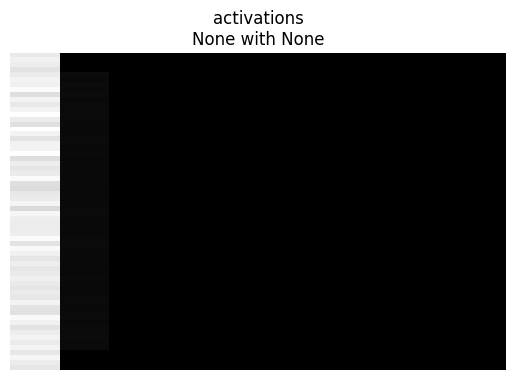

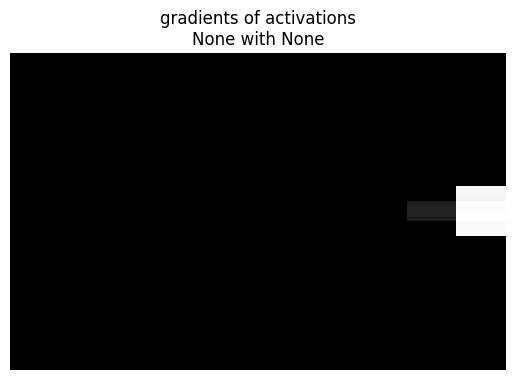

In [212]:
import flax.linen as nn
import jax.numpy as jnp
import jax 
import optax
from functools import partial
from jax.nn.initializers import variance_scaling,he_normal,he_uniform,glorot_normal,glorot_uniform

@partial(jax.grad,argnums=1)
def get_grad(activation,x,target,feature_sizes,weights):
    for f,w in zip(feature_sizes,weights):
        x = nn.Dense(f).apply(w,activation(x))
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=x,labels=target))

def get_heatmaps(key,activation_fn,initializer,input_size,feature_sizes):
    
    weight_init_key, input_key,target_key = jax.random.split(key,num=3)

    model = nn.Sequential([nn.Dense(size,kernel_init=initializer,bias_init=jax.nn.initializers.constant(0)) for size in feature_sizes])
    weights = model.init(weight_init_key,jnp.zeros((1,input_size)))
    weights = [{"params" : weights["params"][key]} for key in weights["params"].keys()]

    input_var = jax.random.normal(input_key,shape=(1000,input_size))
    target_var = jax.random.randint(target_key,shape=(1000,),minval=0,maxval=feature_sizes[-1])

    activations = []
    gradients = []

    x = nn.Dense(feature_sizes[0]).apply(weights[0],input_var)
    activations.append(x)
    for f,w in zip(feature_sizes[1:],weights[1:]):
        x = nn.Dense(f).apply(w,activation_fn(x))
        activations.append(x)

    for a,i in zip(activations,range(len(feature_sizes))):
        g = get_grad(activation_fn,a,target_var,feature_sizes[i+1:],weights[i+1:])
        gradients.append(g)

    activations = [jnp.pad(x,((0,0),(int((max(feature_sizes)-x.shape[1])/2),int((max(feature_sizes)-x.shape[1])/2)))) for x in activations]

    ####
    #activations = [activation(x) for x in activations]
    #####

    gradients = [jnp.pad(x,((0,0),(int((max(feature_sizes)-x.shape[1])/2),int((max(feature_sizes)-x.shape[1])/2)))) for x in gradients]

    return jnp.var(jnp.stack(activations,axis=0),axis=1).T,jnp.var(jnp.stack(gradients,axis=0),axis=1).T

x_l = []
gx_l = []
from tqdm import tqdm

activation = nn.relu
activation_str = "relu"

init = variance_scaling(2, "fan_in", "normal")
init_str = "Kaiming_fan_in"

input_size = 64
#feature_sizes = [64,64,64,64,64,64,64,64,64,10]
feature_sizes = [64,64-8,64-16,64-24,64-32,64-40,64-48,64-56,64-60,10]
#feature_sizes = [64,64+8,64+16,64+24,64+32,64+40,64+48,64+56,64+60,10]
#feature_sizes = [256,128,64,32,10]

for key in tqdm(jax.random.split(jax.random.key(523532),25)):
    x,gx = get_heatmaps(key,activation,init,input_size,feature_sizes)
    x_l.append(x)
    gx_l.append(gx)


x = jnp.mean(jnp.stack(x_l),axis=0)
x = (x - jnp.min(x))/(jnp.max(x)-jnp.min(x))

gx = jnp.mean(jnp.stack(gx_l),axis=0)
gx = (gx - jnp.min(gx))/(jnp.max(gx)-jnp.min(gx))

x_mean = jnp.max(x,axis=0)
gx_mean = jnp.max(gx,axis=0)
x = jnp.repeat(jnp.expand_dims(x,axis=-1),10,axis=-1).reshape((x.shape[0],-1))
gx = jnp.repeat(jnp.expand_dims(gx,axis=-1),10,axis=-1).reshape((gx.shape[0],-1))
import matplotlib.pyplot as plt
plt.axis('off')
plt.title("activations" + "\n" + activation_str + " with " + init_str)
plt.imshow(x, vmin=0, vmax=1,cmap=plt.get_cmap('gray'))
#plt.savefig("./activations" + "_" + activation_str + " with " + init_str + "_ input: " + str(input_size)+ " and features: " + str(feature_sizes)+ ".jpg",dpi=300)

plt.show()

plt.axis('off')
plt.title("gradients of activations" + "\n" + activation_str + " with " + init_str)
plt.imshow(gx, vmin=0, vmax=1,cmap=plt.get_cmap('gray'))
#plt.savefig("./gradients of activations" + "_" + activation_str + " with " + init_str + "_ input: " + str(input_size)+ " and features: " + str(feature_sizes)+ ".jpg",dpi=300)
